# Only run this if you need to tbh, you dont want rewrite the json file

In [64]:
#!/usr/bin/env python3

# standard library modules
import sys, errno, re, json, ssl
from urllib import request
from urllib.error import HTTPError
from time import sleep
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import requests
import xmltodict
import concurrent.futures
import json
import os

In [ ]:
with open('../processed_sequences/annotated_sequences.json', 'w') as f:
    json.dump([],f)

In [78]:

def get_additional_info(seq_data):
    accession = seq_data["Accession_Interpro"]
    url = f"https://rest.uniprot.org/uniprotkb/{accession}.xml"
    response = requests.get(url)
    xml_data = xmltodict.parse(response.text)
    if(response.status_code == 200):
        seq_data["lineage"] = xml_data['uniprot']['entry']['organism']['lineage']["taxon"]
        seq_data["Accession_RefSeq"] = ""
        seq_data["Accession_AlphaFoldDB"] = ""
        for reference in xml_data['uniprot']['entry']['dbReference']:
            try:
                if reference['@type'] == 'RefSeq' or reference['@type'] == 'AlphaFoldDB':
                    id = reference['@id']
                    seq_data["Accession_"+reference["@type"]] = id
            except:
                print(f"\n Failed to get info for {accession}")
                
    else:
        print(f"FAILED RETRIEVING ADDITIONAL DATA FOR {accession}")
    return seq_data


In [100]:
raise Exception("You don't want to run me unless you know what you're doing")

BASE_URL = "https://www.ebi.ac.uk:443/interpro/api/protein/UniProt/entry/InterPro/IPR003776/?page_size=200&extra_fields=sequence&taxonomy"

HEADER_SEPARATOR = "|"


def output_list(next = BASE_URL):
  #disable SSL verification to avoid config issues
  context = ssl._create_unverified_context()
  last_page = False
  total_data = []

  if(next != BASE_URL):
        print("Not starting from the beginning! Loading previous Json!")
        with open('../processed_sequences/annotated_sequences.json', 'r') as f:
            # load the data from the file
            total_data = json.load(f)
        print(f"We have a total of {len(total_data)} sequences!")
        print("\nContinuing where we left off!...\n")
        
  attempts = 0
  while next:
    try:
      req = request.Request(next, headers={"Accept": "application/json"})
      res = request.urlopen(req, context=context)
      # If the API times out due a long running query
      if res.status == 408:
        # wait just over a minute
        sleep(61)
        # then continue this loop with the same URL
        continue
      elif res.status == 204:
        #no data so leave loop
        break
      payload = json.loads(res.read().decode())
      next = payload["next"]
      print(next)
      
      attempts = 0
      if not next:
        last_page = True
    except HTTPError as e:
      if e.code == 408:
        sleep(61)
        continue
      else:
        # If there is a different HTTP error, it wil re-try 3 times before failing
        if attempts < 3:
          attempts += 1
          sleep(61)
          continue
        else:
          sys.stderr.write("LAST URL: " + next)
          raise e
    data = []
    for i, item in enumerate(payload["results"]):
      entries = None
      if ("entry_subset" in item):
        entries = item["entry_subset"]
      elif ("entries" in item):
        entries = item["entries"]
      
      seq_data = {}
      if entries is not None:
        start = 0
        end = 0
        for entry in entries:
          for locations in entry['entry_protein_locations']:
            for fragment in locations['fragments']:
              start = fragment['start']
              end = fragment['end']
        
        seq_data["Accession_Interpro"] = item["metadata"]["accession"]
        seq_data["YcaO_domain"] = {"start":start, "end":end}
      seq_data["seq"] = item["extra_fields"]["sequence"]
      data.append(seq_data)
    with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
        # submit a task to retrieve information for each accession
        tasks = [executor.submit(get_additional_info, seq_data) for seq_data in data]

        # retrieve the results of the tasks as they complete
        results = [task.result() for task in concurrent.futures.as_completed(tasks)]

    
    total_data.extend(data)
    print(f"Processed {len(data)} in the last batch, total {len(total_data)} out of 17 000 sequences")
    # Don't overload the server, give it time before asking for more
    with open('../processed_sequences/annotated_sequences.json', 'w') as f:
        json.dump(total_data,f)
        print("...Progress Saved!")
    with open(filename, "a") as f:
        f.write("\n"+next)
        
  return total_data
print("Hello")
filename = "../processed_sequences/url_progress.txt"
total_data = []
url = BASE_URL
if os.path.exists(filename):
    print("Identified pre existing save, loading... ")
    with open(filename, "r") as f:
        lines = f.readlines()
        if lines:
            url = lines[-1]
else:
    print("Starting to load sequences and identifiers from scratch!")
    open(filename, "w").close()
    
total_data = output_list(url)


Exception: You don't want to run me unless you know what you're doing

In [98]:
total_data = []

with open('../processed_sequences/annotated_sequences.json', 'r') as f:
    total_data = json.load(f)
#total_data

In [99]:
def transform_list(data, result={}):
    for item in data:
        lineage = item["lineage"]
        if lineage:
            lineage_dict = result
            for level in lineage:
                if level not in lineage_dict:
                    lineage_dict[level] = {}
                lineage_dict = lineage_dict[level]
            lineage_dict.update(item)
    return result

transformed_data = transform_list(total_data)


In [113]:
def get_sequences(data, family):
    return [s for s in data if family in s['lineage']]

In [110]:
from collections import defaultdict
import matplotlib.pyplot as plt

def Draw_Pie(depth=2):
    # Create a defaultdict to store the count of each lineage
    lineage_count = defaultdict(int)

    # Iterate through the list of dictionaries and count the occurrences of each lineage
    for item in total_data:
        try:
            lineage_count[item["lineage"][depth]] += 1
        except:
            continue
            
    # Extract the labels (lineage names) and sizes (counts) for the pie chart
    labels = list(lineage_count.keys())
    sizes = list(lineage_count.values())

    # Create the pie chart
    plt.pie(sizes, labels=labels, autopct='%1.1f%%')
    plt.axis('equal')  # Ensure the chart is a circle, not an ellipse
    plt.legend(bbox_to_anchor=(1.1, 1.05))

    plt.show()

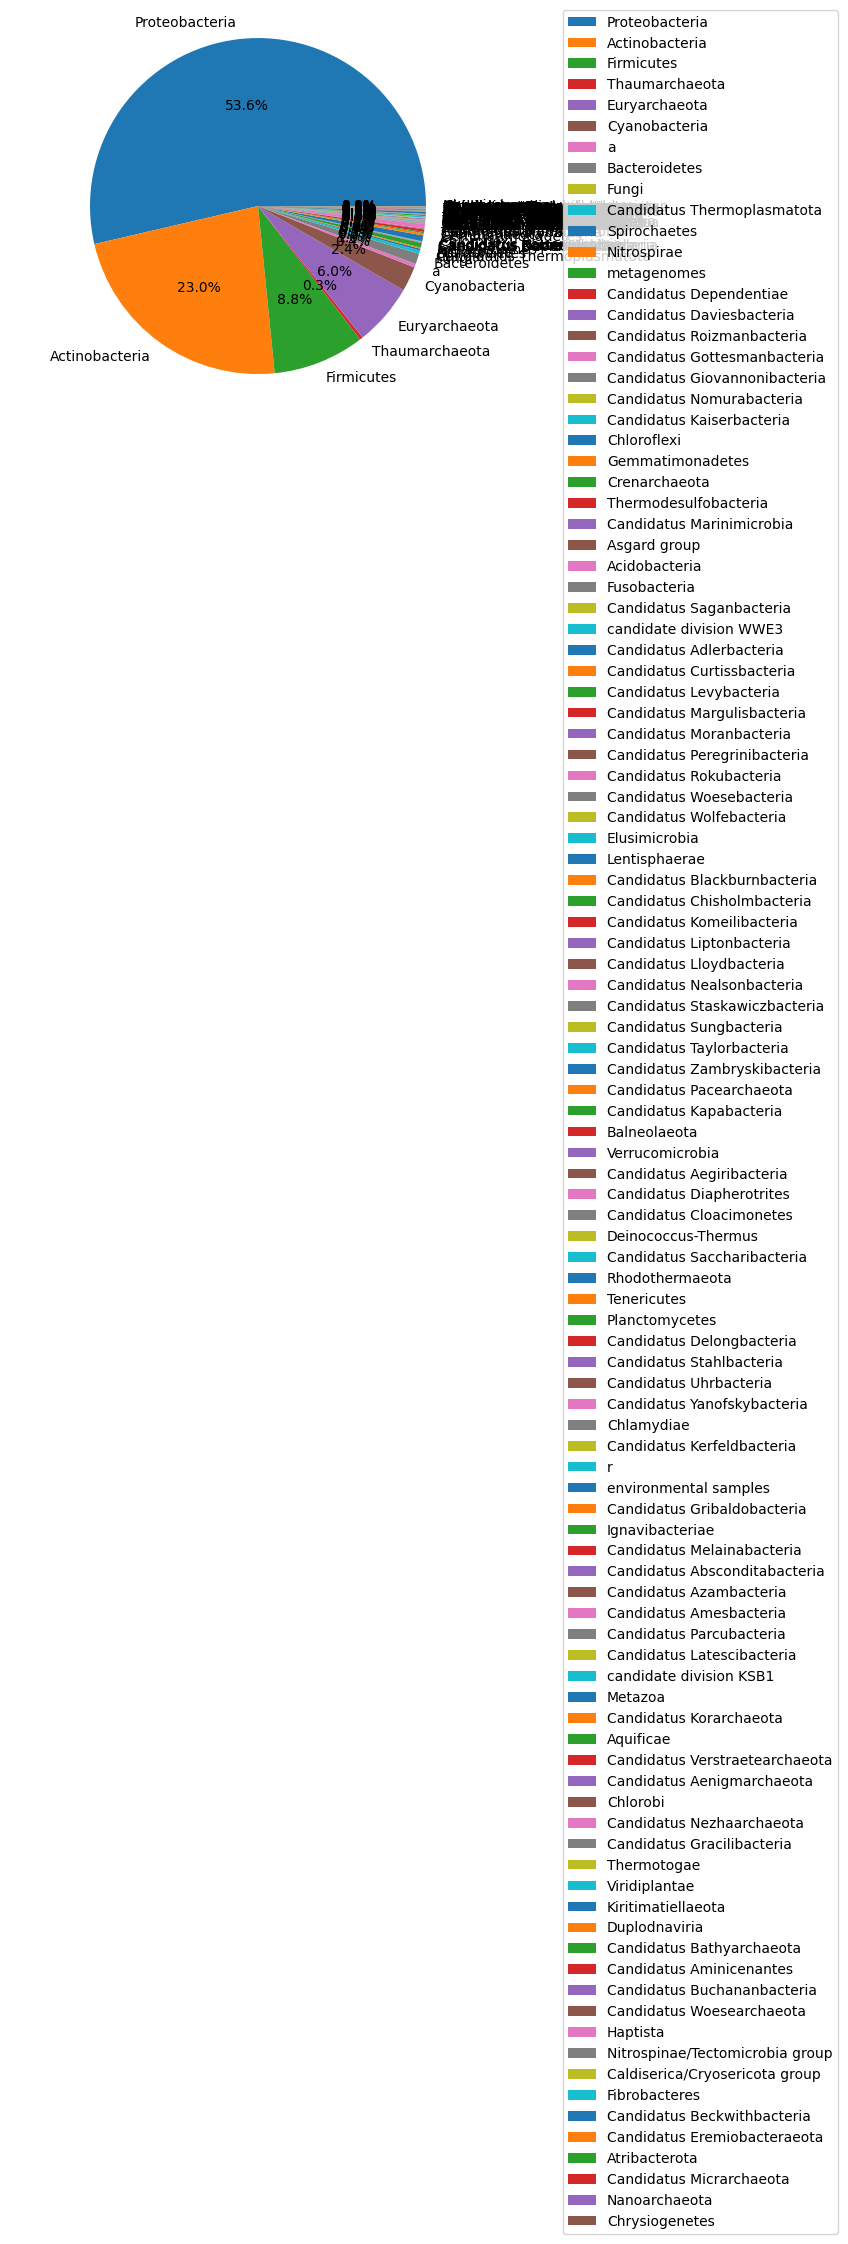

In [112]:
Draw_Pie(1)

In [134]:
import Bio as bio
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import os

family = "Cyanobacteria"
filterByDomain = True

sequences = get_sequences(total_data,family)
seq_recs = []
for seq_data in sequences:
    seq = Seq(seq_data["seq"])
    if(filterByDomain):
        seq = seq[seq_data["YcaO_domain"]["start"]:seq_data["YcaO_domain"]["end"]]
    seq_recs.append(SeqRecord(seq, id=seq_data["Accession_Interpro"]))

dirname = f'../processed_sequences/{family}_sequences'
filename = f"{family}_{'YcaO_only' if filterByDomain else 'whole_protein'}.fa"

if not os.path.exists(dirname):
    # Create the directory
    os.makedirs(dirname)
    
SeqIO.write(seq_recs,os.path.join(dirname,filename), "fasta")

394